In [7]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns

from point import ClusterPoint as CP
from boxgraph import BoxGraph
from dbscan_boxgraph_implementation import find_core_points, compute_cluster_cores, assign_border_points

from point import Point, ClusterPoint
from square import Square
from node import Node

from db_scan import *
from dataset import *
from range_query import RangeQuery, LinearQuery
from dbscan_quadtree_implentation import QuadTree

In [13]:
# Font size for plots
FONT_SIZE = 14

## Helper methods

In [2]:
def df_to_latex_table(df, caption, label):
    df = df.round(5)
    from io import StringIO

    # Start building LaTeX table
    output = StringIO()
    num_cols = len(df.columns)

    # Begin table environment
    output.write("\\begin{table}[H]\n")
    output.write("    \\centering\n")
    output.write("    \\footnotesize\n")
    output.write("    \\renewcommand{\\arraystretch}{1.3} % Adds row height for better readability\n")
    
    # Column format: first column left-aligned, rest flexible (X)
    col_format = "|l" + "|X" * (num_cols - 1) + "|"
    output.write(f"    \\begin{{tabularx}}{{\\textwidth}}{{{col_format}}}\n")
    output.write("        \\hline\n")
    
    # Column headers
    # headers = " & ".join([f"\\textbf{{{col.replace('_', '\_')}}}" for col in df.columns]) + " \\\\"
    cols = [col.replace('_', '\_') for col in df.columns]
    headers = " & ".join([f"\\textbf{{{col}}}" for col in cols]) + " \\\\"
    output.write(f"        {headers}\n")
    output.write("         \\hline\n")
    
    # Data rows
    for _, row in df.iterrows():
        values = " & ".join(str(cell).replace('_', '\_').replace('%', '\%') for cell in row) + " \\\\"
        output.write(f"         {values}\n")
    
    output.write("         \\hline\n")
    output.write("    \\end{tabularx}\n")
    output.write(f"    \\caption{{{caption}}}\n")
    output.write(f"    \\label{{{label}}}\n")
    output.write("\\end{table}\n")

    return output.getvalue()

def df_to_latex_table2(df, caption, label):
    df = df.round(5)
    from io import StringIO

    output = StringIO()
    num_cols = len(df.columns)

    # Begin LaTeX table
    output.write("\\begin{table}[H]\n")
    output.write("    \\centering\n")
    output.write("    \\footnotesize\n")
    output.write("    \\renewcommand{\\arraystretch}{1.3} % Adds row height for better readability\n")

    # Use tabularx for flexible-width columns
    col_format = "|l" + "|X" * (num_cols - 1) + "|"
    output.write(f"    \\begin{{tabularx}}{{\\textwidth}}{{{col_format}}}\n")
    output.write("        \\hline\n")

    # Header row
    headers = [f"\\textbf{{{str(col).replace('_', '\\_')}}}" for col in df.columns]
    output.write("        " + " & ".join(headers) + " \\\\\n")
    output.write("        \\hline\n")

    # Data rows
    for _, row in df.iterrows():
        values = [
            str(cell).replace('_', '\\_').replace('%', '\\%') 
            for cell in row
        ]
        output.write("        " + " & ".join(values) + " \\\\\n")

    output.write("        \\hline\n")
    output.write("    \\end{tabularx}\n")
    output.write(f"    \\caption{{{caption}}}\n")
    output.write(f"    \\label{{{label}}}\n")
    output.write("\\end{table}\n")

    return output.getvalue()

## DBSCAN Algorithm Wrappers

In [3]:
def run_dbscan_linear(points, eps, min_pts):
    # ─── Step 1: Convert raw coordinates to ClusterPoint objects ───
    cp_points = [ClusterPoint(2, [float(x), float(y)]) for x, y in points]

    # ─── Step 2: Initialize linear range query (no spatial structure) ───
    start_init = time.perf_counter()
    query_obj = LinearQuery(cp_points)  # minimal setup time
    init_time = time.perf_counter() - start_init

    # ─── Step 3: Run the DBSCAN clustering algorithm ───
    start_query = time.perf_counter()
    nr_clusters = find_clustering(cp_points, eps, min_pts, query_obj)
    query_time = time.perf_counter() - start_query

    # ─── Step 4: Collect labels and timings ───
    labels = [p.cluster_label for p in cp_points]
    return labels, {"init": init_time, "range_queries": query_time}

def run_dbscan_quadtree(points, eps, min_pts):
    # ─── Step 1: Wrap raw points in ClusterPoint objects ───
    cp_points = [ClusterPoint(2, [float(x), float(y)]) for x, y in points]

    # ─── Step 2: Setup timing for quadtree creation ───
    start_init = time.perf_counter()
    query_obj = QuadTree(cp_points)  # this builds the tree
    init_time = time.perf_counter() - start_init

    # ─── Step 3: Run clustering using the quadtree ───
    start_query = time.perf_counter()
    nr_clusters = find_clustering(cp_points, eps, min_pts, query_obj)
    query_time = time.perf_counter() - start_query

    # ─── Step 4: Return cluster labels and timing ───
    labels = [p.cluster_label for p in cp_points]
    return labels, {"init": init_time, "range_queries": query_time}

def run_dbscan_boxgraph(points, eps, min_pts):
    # ─── Step 1: Convert numpy points → ClusterPoint objects ───
    cp_points = [CP(2, [float(x), float(y)]) for x, y in points]
    n = len(cp_points)
    d = 2

    # ─── Step 2: Build BoxGraph ───
    start_init = time.perf_counter()
    bg = BoxGraph(n, d, eps, min_pts, cp_points)
    init_time = time.perf_counter() - start_init

    # ─── Step 3: Clustering steps ───
    start_query = time.perf_counter()
    find_core_points(bg)
    compute_cluster_cores(bg)
    assign_border_points(bg)
    query_time = time.perf_counter() - start_query

    # ─── Step 4: Return cluster labels and timings ───
    labels = [p.cluster_label for p in cp_points]
    return labels, {"init": init_time, "range_queries": query_time}

## Experiment Configuration

In [4]:
# First check if you already have the results so you can load them (saves a lot of time)
if os.path.isfile('results.csv'):
    load_results = input('results.csv is available. Do you want to load it (saves time)? [y/n]')
    if load_results.strip().lower() == 'y':
        df = pd.read_csv('results.csv')
        LOADED = True
    else:
        LOADED = False
else:
    LOADED = False

if not LOADED:  # Check if the csv file with the results was loaded, if not then compute the results
    print("Computing results. This will take a while (around 5 mins)...")
    
    eps = 0.5
    min_pts = 5
    np.random.seed(42)
    
    # Sizes and noise levels to test
    # grid_N = [1_000, 10_000, 100_000, 500_000]
    grid_N = [1_000, 10_000]
    noise_ratios = [0.0, 0.2, 0.5]    # fraction of points uniformly at random
    
    results = []
    total = len(grid_N) * len(noise_ratios) * 3  # 3 is the number of methods used

    p_bar = tqdm(desc='Computing ', total=total)
    for N in grid_N:
        for noise_frac in noise_ratios:
            n_noise = int(N * noise_frac)
            n_clusters = N - n_noise
            # Generate clustered data
            Xc, _ = make_blobs(n_samples=n_clusters,
                               centers=[(-5,-5),(5,5),(5,-5),(-5,5)],
                               cluster_std=1.0, random_state=42)
            # Generate uniform noise
            Xn = np.random.uniform(low=-10, high=10, size=(n_noise, 2))
            X = np.vstack([Xc, Xn])
    
            for name, runner in [
                ("linear",    run_dbscan_linear),
                ("quadtree",  run_dbscan_quadtree),
                ("boxgraph",  run_dbscan_boxgraph),
            ]:
                p_bar.update(1)
                p_bar.set_postfix_str(f'name={name}; N={N}; noise={noise_frac}')
                labels, timing = runner(X, eps, min_pts)
                total_time = timing["init"] + timing["range_queries"]
                results.append({
                    "method": name,
                    "N": N,
                    "noise_frac": noise_frac,
                    "init_time": timing["init"],
                    "query_time": timing["range_queries"],
                    "total_time": total_time
                })
    
    # Aggregate into DataFrame
    df = pd.DataFrame(results)
    df.to_csv('results.csv')

# Print summary table
print(df.groupby(["method","noise_frac","N"])["total_time"].mean().unstack("method"))

Computing results. This will take a while (around 5 mins)...


Computing : 100%|█| 18/18 [04:33<00:00, 25.97s/it, name=boxgraph; N=10000; noise

method            boxgraph     linear   quadtree
noise_frac N                                    
0.0        1000   0.007882   0.731622   0.525113
           10000  0.127895  76.092138  25.095162
0.2        1000   0.007264   0.684223   0.369970
           10000  0.107962  74.922418  19.057611
0.5        1000   0.006408   0.636198   0.248127
           10000  0.095874  64.084202  11.140647


## Plot

In [5]:
# fig, ax = plt.subplots()
# for method in df["method"].unique():
#     sub = df[df["method"] == method]
#     ax.plot(sub["N"], sub["total_time"], marker='o', label=method)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Number of points N")
# ax.set_ylabel("Average total runtime (s)")
# ax.legend()
# ax.set_title(f"DBSCAN scaling, noise={noise_ratios}")
# plt.tight_layout()
# plt.show()

In [6]:
table = df_to_latex_table2(df, 'Results for different DBSCAN algorithms, N, and noise ratio', 'tab:results_main')
print(table)

\begin{table}[H]
    \centering
    \footnotesize
    \renewcommand{\arraystretch}{1.3} % Adds row height for better readability
    \begin{tabularx}{\textwidth}{|l|X|X|X|X|X|}
        \hline
        \textbf{method} & \textbf{N} & \textbf{noise\_frac} & \textbf{init\_time} & \textbf{query\_time} & \textbf{total\_time} \\
        \hline
        linear & 1000 & 0.0 & 0.0 & 0.73162 & 0.73162 \\
        quadtree & 1000 & 0.0 & 0.00476 & 0.52035 & 0.52511 \\
        boxgraph & 1000 & 0.0 & 0.00153 & 0.00635 & 0.00788 \\
        linear & 1000 & 0.2 & 0.0 & 0.68422 & 0.68422 \\
        quadtree & 1000 & 0.2 & 0.00476 & 0.36521 & 0.36997 \\
        boxgraph & 1000 & 0.2 & 0.00184 & 0.00543 & 0.00726 \\
        linear & 1000 & 0.5 & 0.0 & 0.6362 & 0.6362 \\
        quadtree & 1000 & 0.5 & 0.00451 & 0.24362 & 0.24813 \\
        boxgraph & 1000 & 0.5 & 0.00188 & 0.00453 & 0.00641 \\
        linear & 10000 & 0.0 & 0.0 & 76.09214 & 76.09214 \\
        quadtree & 10000 & 0.0 & 0.08422 & 25.01095 & 2

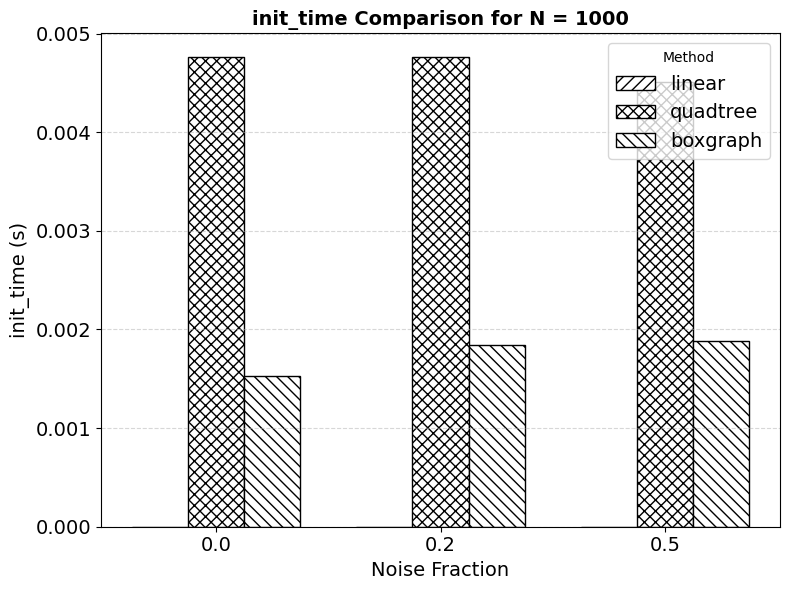

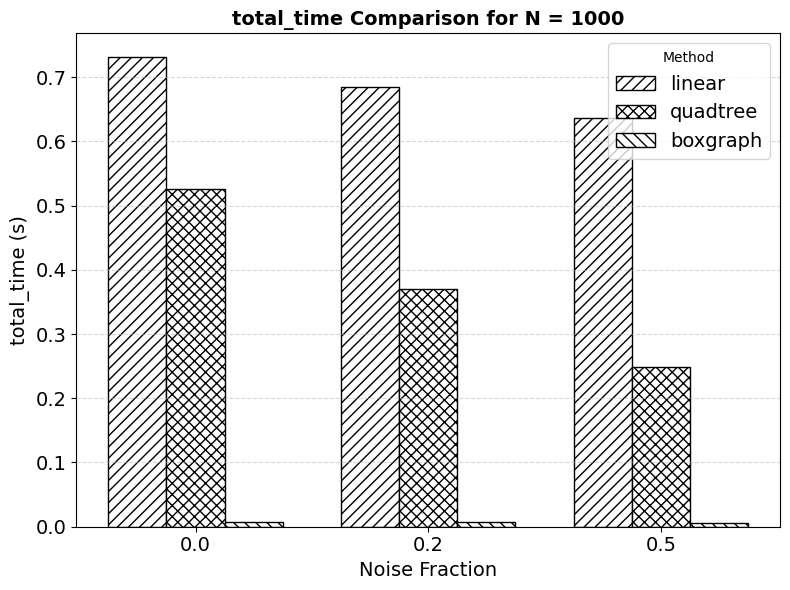

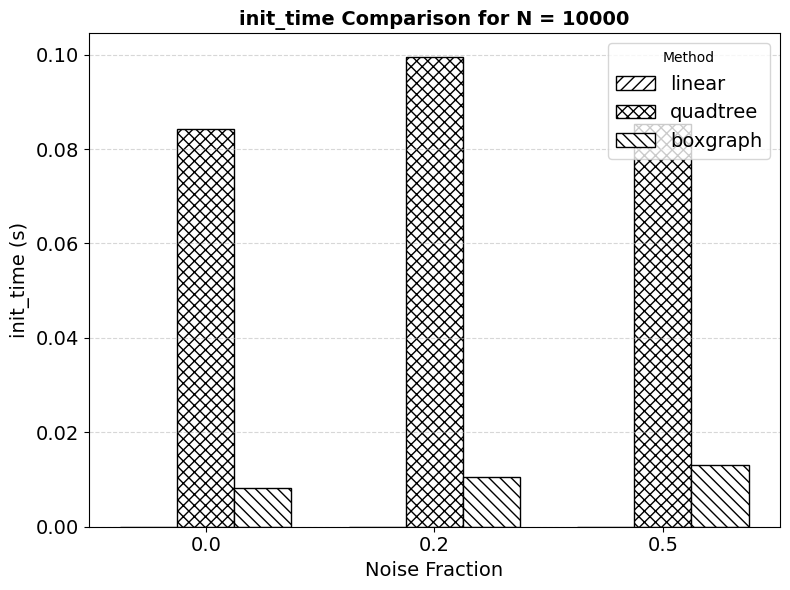

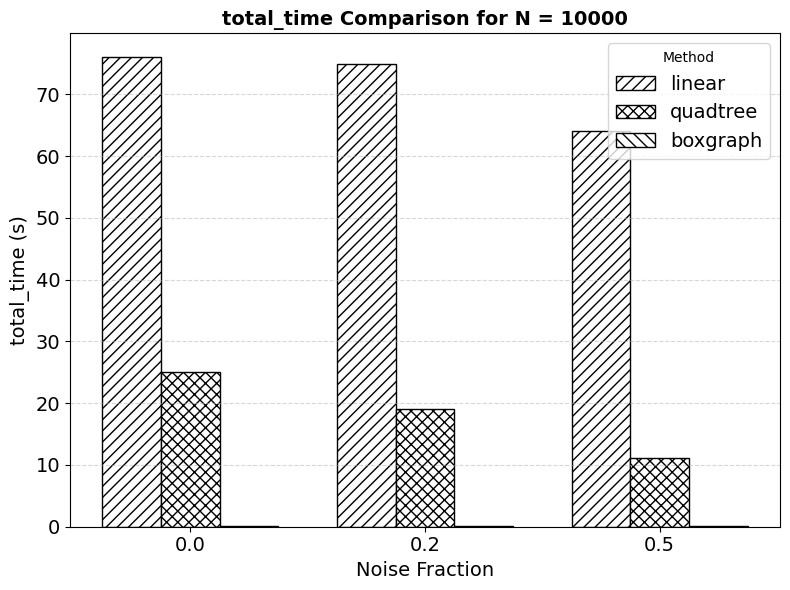

In [26]:
df = pd.read_csv('results.csv')


# Define hatches and plot styles
methods = ['linear', 'quadtree', 'boxgraph']
hatches = ['///', 'xxx', '\\\\\\']
palette = ['white'] * 3     # keeps bar fill white
edgecolor = 'black'

# Create a plot for each N
for N_val in [1000, 10000]:
    for run_time_type in ['init_time', 'total_time']:
        df_N = df[df['N'] == N_val]
    
        # Pivot data to prepare for grouped bar plot
        pivot = df_N.pivot_table(index='noise_frac', columns='method', values=run_time_type)
    
        # Sort to ensure consistent order
        pivot = pivot.reindex(sorted(pivot.index))
    
        # Plot setup
        fig, ax = plt.subplots(figsize=(8, 6))
        x = np.arange(len(pivot.index))  # noise_frac positions
        width = 0.25
    
        for i, method in enumerate(methods):
            times = pivot[method]
            bars = ax.bar(
                x + i * width,
                times,
                width,
                label=method,
                color=palette,
                edgecolor=edgecolor,
                hatch=hatches[i]
            )
    
        # Axes formatting
        ax.set_xlabel('Noise Fraction', fontsize=FONT_SIZE)
        ax.set_ylabel(f'{run_time_type} (s)', fontsize=FONT_SIZE)
        ax.set_title(f'{run_time_type} Comparison for N = {N_val}', fontsize=FONT_SIZE, fontweight='bold')
        ax.set_xticks(x + width)
        plt.xticks(fontsize=FONT_SIZE)
        plt.yticks(fontsize=FONT_SIZE)
        ax.set_xticklabels(pivot.index)
        ax.legend(title="Method", fontsize=FONT_SIZE)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
        
    
        plt.tight_layout()
        plt.savefig(f'plots/result_{N_val}_{run_time_type}.pdf')
        plt.show()